In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
#os.listdir("/data/saved_models/")

# CycleGAN

#### Directory structure:
- **data/** contains the datasets.
    - **data/&lt;dataset&gt;/{train_A, train_B}/** contains training images for classes A and B.
    - **data/&lt;dataset&gt;/{test_A, test_B}/** contains testing images that are not used during training. These are useful to evaluate the generalization of the model to new data.
- **images/** stores metadata and loss information of each CycleGAN run, as well as evaluation images.
    - **images/meta_data.json** contains the settings of the run.
    - **images/loss_output.csv** contains the various losses of the model, stored after every batch.
    - **images/{train_A, train_B, test_A, test_B}** contains intermediate evaluation images for each epoch, illustrating generator performance.
    - **images/tmp.png** shows example image translations from the current moment in training. This image updates in real time and can be used to see how the training converges.
- **saved_models** stores the generator and discriminator models resulting from each run, which are saved every 20 epochs.

Tomado de:
https://github.com/brainhack101/IntroDL/blob/master/notebooks/2019/Eklund/CycleGAN.ipynb

!rm -rf __pycache__

!wget -nc https://raw.githubusercontent.com/brainhack101/IntroDL/master/notebooks/2019/Eklund/requirements-gpu.txt

!pip install -r requirements-gpu.txt

In [3]:
from keras.layers import Layer, Input, Dropout, Conv2D, Activation, add, UpSampling2D, Conv2DTranspose, Flatten
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization, InputSpec
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.models import Model
from keras.engine.topology import Network

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from progress.bar import Bar
import datetime
import time
import json
import csv
import sys
import os

import keras.backend as K
import tensorflow as tf

import keras as ke
#print(tf.__version__)
#print(ke.__version__)

Using TensorFlow backend.


Additional functions are contained in the `helper_functions.py` file. These mostly include code for loading the data and saving the resutls.

!wget https://raw.githubusercontent.com/brainhack101/IntroDL/master/notebooks/2019/Eklund/helper_funcs.py

In [4]:
#from helper_funcs import *
#from helper_funcs2 import *
from helper_funcs3 import *

If you have multiple GPUs you can select a single one of them by setting the visible CUDA device to 0, 1, ...

#### Load data

The dataset used for the run is **data/&lt;`image_folder`&gt;**.

In [5]:
#image_folder = 'customnoss'
#image_folder = 'custom'

#image_folder = 'customnoss-ncct2dwi'
#image_folder = 'customnoss-adc2dwi'
#image_folder = 'customnoss-ncct2adc'

#image_folder = 'custom-ncct2dwi'
#image_folder = 'custom-adc2dwi'

#image_folder = 'custom-ncct2adc'
image_folder = 'custom-pruebas'

data = load_data(subfolder=image_folder)

### Model parameters

This CycleGAN implementation allows a lot of freedom on both the training parameters and the network architecture.

In [6]:
opt = {}

# Data
opt['channels'] = data["nr_of_channels"]
opt['img_shape'] = data["image_size"] + (opt['channels'],)
print('Image shape: ', opt['img_shape'])

opt['A_train'] = data["trainA_images"]
opt['B_train'] = data["trainB_images"]
opt['A_test'] = data["testA_images"]
opt['B_test'] = data["testB_images"]
opt['testA_image_names'] = data["testA_image_names"]
opt['testB_image_names'] = data["testB_image_names"]

opt['trainA_image_names'] = data["trainA_image_names"]
opt['trainB_image_names'] = data["trainB_image_names"]

# opt['CTFOSCAL_images'] = data["CTFOSCAL_images"]
# opt['CTFOSCAL_image_names'] = data["CTFOSCAL_image_names"]
# opt['CTHEALTHY_images'] = data["CTHEALTHY_images"]
# opt['CTHEALTHY_image_names'] = data["CTHEALTHY_image_names"]

# print(opt['A_train'].shape)
# print(opt['B_train'].shape)

# print(opt['CTFOSCAL_images'].shape)
# print(len(opt['CTFOSCAL_image_names']))
# print(opt['CTHEALTHY_images'].shape)
# print(len(opt['CTHEALTHY_image_names']))

Image shape:  (256, 256, 1)


CylceGAN can be used both on paired and unpaired data. The `paired_data` setting affects the presentation of output images as explained above.

In [7]:
#opt['paired_data'] = True
opt['paired_data'] = False

#### Training parameters
- `lambda_ABA` and `lambda_BAB` set the importance of the cycle consistency losses in relation to the adversarial loss `lambda_adversarial`
- `learning_rate_D` and `learning_rate_G` are the learning rates for the discriminators and generators respectively.
- `generator_iterations` and `discriminator_iterations` represent how many times the generators or discriminators will be trained on every batch of images. This is very useful to keep the training of both systems balanced. In this case the discriminators become successful faster than the generators, so we account for this by training the generators 3 times on every batch of images.
- `synthetic_pool_size` sets the size of the image pool used for training the discriminators. The image pool has a certain probability of returning a synthetic image from previous iterations, thus forcing the discriminator to have a certain "memory". More information on this method can be found in [this paper](https://arxiv.org/abs/1612.07828).
- `beta_1` and `beta_2` are paremeters of the [Adam](https://arxiv.org/abs/1412.6980) optimizers used on the generators and discriminators.
- `batch_size` determines the number of images used for each update of the network weights. Due to the significant memory requirements of CycleGAN it is difficult to use a large batch size. For the small example dataset values between 1-30 may be possible.
- `epochs` sets the number of training epochs. Each epoch goes through all the training images once. The number of epochs necessary to train a model is therefore dependent on both the number of training images available and the batch size.

In [8]:
# Training parameters
opt['lambda_ABA'] = 10.0  # Cyclic loss weight A_2_B
opt['lambda_BAB'] = 10.0  # Cyclic loss weight B_2_A
opt['lambda_adversarial'] = 1.0  # Weight for loss from discriminator guess on synthetic images
opt['learning_rate_D'] = 2e-4
opt['learning_rate_G'] = 2e-4
opt['generator_iterations'] = 3  # Number of generator training iterations in each training loop
opt['discriminator_iterations'] = 1  # Number of discriminator training iterations in each training loop
opt['synthetic_pool_size'] = 50  # Size of image pools used for training the discriminators
opt['beta_1'] = 0.5  # Adam parameter
opt['beta_2'] = 0.999  # Adam parameter
opt['batch_size'] = 16  # Number of images per batch
opt['epochs'] = 100 # Choose multiples of 20 since the models are saved each 20th epoch

In [9]:
# Output parameters
opt['save_models'] = True  # Save or not the generator and discriminator models
opt['save_training_img'] = True  # Save or not example training results or only tmp.png
opt['save_training_img_interval'] = 1  # Number of epoch between saves of intermediate training results
opt['self.tmp_img_update_frequency'] = 3  # Number of batches between updates of tmp.png

#### Architecture parameters
- `use_instance_normalization` is supposed to allow the selection of instance normalization or batch normalization layes. At the moment only instance normalization is implemented, so this option does not do anything.
- `use_dropout` and `use_bias` allows setting droupout layers in the generators and whether to use a bias term in the various convolutional layer in the genrators and discriminators.
- `use_linear_decay` applies linear decay on the learning rates of the generators and discriminators,   `decay_epoch`
- `use_patchgan` determines whether the discriminator evaluates the "realness" of images on a patch basis or on the whole. More information on PatchGAN can be found in [this paper](https://arxiv.org/abs/1611.07004).
- `use_resize_convolution` provides two ways to perfrom the upsampling in the generator, with significant differences in the results. More information can be found in [this article](https://distill.pub/2016/deconv-checkerboard/). Each has its advantages, and we have managed to get successful result with both methods
- `use_discriminator sigmoid` adds a sigmoid activation at the end of the discrimintator, forcing its output to the (0-1) range.

In [10]:
# Architecture parameters
opt['use_instance_normalization'] = True  # Use instance normalization or batch normalization
opt['use_dropout'] = False  # Dropout in residual blocks
opt['use_bias'] = True  # Use bias
opt['use_linear_decay'] = True  # Linear decay of learning rate, for both discriminators and generators
opt['decay_epoch'] = 100  # The epoch where the linear decay of the learning rates start
opt['use_patchgan'] = True  # PatchGAN - if false the discriminator learning rate should be decreased
opt['use_resize_convolution'] = False  # Resize convolution - instead of transpose convolution in deconvolution layers (uk) - can reduce checkerboard artifacts but the blurring might affect the cycle-consistency
opt['discriminator_sigmoid'] = True  # Add a final sigmoid activation to the discriminator

In [11]:
# Tweaks
opt['REAL_LABEL'] = 1.0  # Use e.g. 0.9 to avoid training the discriminators to zero loss

### Model architecture

#### Layer blocks
These are the individual layer blocks that are used to build the generators and discriminator. More information can be found in the appendix of the [CycleGAN paper](https://arxiv.org/abs/1703.10593).

In [12]:
# Discriminator layers
def ck(model, opt, x, k, use_normalization, use_bias):
    x = Conv2D(filters=k, kernel_size=4, strides=2, padding='same', use_bias=use_bias)(x)
    if use_normalization:
        x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = LeakyReLU(alpha=0.2)(x)
    return x

# First generator layer
def c7Ak(model, opt, x, k):
    x = Conv2D(filters=k, kernel_size=7, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)
    return x

# Downsampling
def dk(model, opt, x, k):  # Should have reflection padding
    x = Conv2D(filters=k, kernel_size=3, strides=2, padding='same', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)
    return x

# Residual block
def Rk(model, opt, x0, n):
    k = int(x0.shape[-1])

    # First layer
    x = ReflectionPadding2D((1,1))(x0)
    x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)

    if opt['use_dropout']:
        x = Dropout(0.5)(x)

    # Second layer
    x = ReflectionPadding2D((1, 1))(x)
    x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    # Merge
    x = add([x, x0], name='add'+str(n))

    return x

# Upsampling
def uk(model, opt, x, k):
    # (up sampling followed by 1x1 convolution <=> fractional-strided 1/2)
    if opt['use_resize_convolution']:
        x = UpSampling2D(size=(2, 2))(x)  # Nearest neighbor upsampling
        x = ReflectionPadding2D((1, 1))(x)
        x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    else:
        x = Conv2DTranspose(filters=k, kernel_size=3, strides=2, padding='same', use_bias=opt['use_bias'])(x)  # this matches fractionally stided with stride 1/2
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)
    return x

#### Architecture functions

In [13]:
def build_discriminator(model, opt, name=None):
    # Input
    input_img = Input(shape=opt['img_shape'])

    # Layers 1-4
    x = ck(model, opt, input_img, 64, False, True) #  Instance normalization is not used for this layer)
    x = ck(model, opt, x, 128, True, opt['use_bias'])
    x = ck(model, opt, x, 256, True, opt['use_bias'])
    x = ck(model, opt, x, 512, True, opt['use_bias'])

    # Layer 5: Output
    if opt['use_patchgan']:
        x = Conv2D(filters=1, kernel_size=4, strides=1, padding='same', use_bias=True)(x)
    else:
        x = Flatten()(x)
        x = Dense(1)(x)

    if opt['discriminator_sigmoid']:
        x = Activation('sigmoid')(x)

    return Model(inputs=input_img, outputs=x, name=name)

def build_generator(model, opt, name=None):
    # Layer 1: Input
    input_img = Input(shape=opt['img_shape'])
    x = ReflectionPadding2D((3, 3))(input_img)
    x = c7Ak(model, opt, x, 32)

    # Layer 2-3: Downsampling
    x = dk(model, opt, x, 64)
    x = dk(model, opt, x, 128)

    # Layers 4-12: Residual blocks
    for _ in range(4, 13):
        x = Rk(model, opt, x, _)

    # Layer 13:14: Upsampling
    x = uk(model, opt, x, 64)
    x = uk(model, opt, x, 32)

    # Layer 15: Output
    x = ReflectionPadding2D((3, 3))(x)
    x = Conv2D(opt['channels'], kernel_size=7, strides=1, padding='valid', use_bias=True)(x)
    x = Activation('tanh')(x)

    return Model(inputs=input_img, outputs=x, name=name)

#### CasNet generator

In [14]:
#@title Generator
from keras import layers

def u_block(input_tensor, 
            encoder_num_filters=[64, 128, 256, 512, 512, 512, 512, 512],
            decoder_num_filters=[512, 1024, 1024, 1024, 1024, 512, 256, 128],
            use_instance_norm=True,
            block_prefix=''):
    
    x = input_tensor
    encoder_blocks_outputs = []
    
    # Encoder path.
    for i, num_filters in enumerate(encoder_num_filters):
        x = layers.Conv2D(num_filters, 
                          kernel_size=4, 
                          strides=2, 
                          padding='same', 
                          name=f'{block_prefix}_EncoderBlock{i+1}-Conv')(x)
        if use_instance_norm:
            x = InstanceNormalization(name=f'{block_prefix}_EncoderBlock{i+1}-Instancenorm')(x)
        else:
            x = layers.BatchNormalization(name=f'{block_prefix}_EncoderBlock{i+1}-Batchnorm')(x)
        x = layers.Activation('relu', name=f'{block_prefix}_EncoderBlock{i+1}-ReLU')(x)
        
        # Append the encoder blocks outputs, except for the last one.
        if i != len(encoder_num_filters) - 1: 
            encoder_blocks_outputs.append(x)

    # Decoder path.
    for i, num_filters in enumerate(decoder_num_filters):
        x = layers.Conv2DTranspose(
            num_filters, 
            kernel_size=(4, 4), 
            strides=(2, 2), 
            padding='same',
            name=f'{block_prefix}_DecoderBlock{i+1}-TransposedConv'
        )(x)
        x = layers.Activation('relu', name=f'{block_prefix}_DecoderBlock{i+1}-ReLU')(x)

        # All the decoder blocks have concatenate the encoder block output with
        # the same spatial dimentions except for the last one.
        if i != len(decoder_num_filters) - 1: 
            x = layers.Concatenate(
                name=f'{block_prefix}_DecoderBlock{i+1}-Concat'
            )([encoder_blocks_outputs[-(i + 1)], x])

    # Last operation: 1x1 conv to map the image to the input n_channels.
    x = layers.Conv2D(1,   #input_tensor.shape[-1]
                      kernel_size=(1, 1), 
                      name=f'{block_prefix}_Decoder-Conv1x1')(x)
    output = layers.Activation('tanh', name=f'{block_prefix}_Decoder-Tanh')(x)

    return output

def build_casnet_generator(input_shape=(256, 256, 1), 
                           n_blocks=2, 
                           use_instance_norm=True,
                           name=None):
    """Create a CasNet Generator using UBlocks"""
    input_tensor = Input(shape=input_shape)
    x = input_tensor
    for i in range(n_blocks):
        x = u_block(x, block_prefix=f'UBlock{i+1}', use_instance_norm=use_instance_norm)
    
    return Model(inputs=input_tensor, outputs=x, name=name)

#### Loss functions
The discriminators use MSE loss. The generators use MSE for the adversarial losses and MAE for the cycle consistency losses.

In [15]:
# Mean squared error
def mse(y_true, y_pred):
    loss = tf.reduce_mean(tf.squared_difference(y_pred, y_true))
    return loss

# Mean absolute error
def mae(y_true, y_pred):
    loss = tf.reduce_mean(tf.abs(y_pred - y_true))
    return loss

#### Build CycleGAN model

In [16]:
model = {}

# Normalization
model['normalization'] = InstanceNormalization

# Optimizers
model['opt_D'] = Adam(opt['learning_rate_D'], opt['beta_1'], opt['beta_2'])
model['opt_G'] = Adam(opt['learning_rate_G'], opt['beta_1'], opt['beta_2'])

# Build discriminators
D_A = build_discriminator(model, opt, name='D_A')
D_B = build_discriminator(model, opt, name='D_B')

# Define discriminator models
image_A = Input(shape=opt['img_shape'])
#print(image_A.shape)
image_B = Input(shape=opt['img_shape'])
guess_A = D_A(image_A)
guess_B = D_B(image_B)
model['D_A'] = Model(inputs=image_A, outputs=guess_A, name='D_A_model')
model['D_B'] = Model(inputs=image_B, outputs=guess_B, name='D_B_model')

# Compile discriminator models
loss_weights_D = [0.5]  # 0.5 since we train on real and synthetic images
model['D_A'].compile(optimizer=model['opt_D'],
                 loss=mse,
                 loss_weights=loss_weights_D)
model['D_B'].compile(optimizer=model['opt_D'],
                 loss=mse,
                 loss_weights=loss_weights_D)

# Use containers to make a static copy of discriminators, used when training the generators
model['D_A_static'] = Network(inputs=image_A, outputs=guess_A, name='D_A_static_model')
model['D_B_static'] = Network(inputs=image_B, outputs=guess_B, name='D_B_static_model')

# Do not update discriminator weights during generator training
model['D_A_static'].trainable = False
model['D_B_static'].trainable = False

# Build generators
model['G_A2B'] = build_generator(model, opt, name='G_A2B_model')
model['G_B2A'] = build_generator(model, opt, name='G_B2A_model')

#model['G_A2B'] = build_casnet_generator(input_shape=(256,256,1), n_blocks=1, name='G_A2B_model')
#model['G_B2A'] = build_casnet_generator(input_shape=(256,256,1), n_blocks=1, name='G_B2A_model')

#print("G_A2B")
#model['G_A2B'].summary()
#print("G_B2A")
#model['G_B2A'].summary()

# Define full CycleGAN model, used for training the generators
real_A = Input(shape=opt['img_shape'], name='real_A')
real_B = Input(shape=opt['img_shape'], name='real_B')
synthetic_B = model['G_A2B'](real_A)
synthetic_A = model['G_B2A'](real_B)
dB_guess_synthetic = model['D_B_static'](synthetic_B)
dA_guess_synthetic = model['D_A_static'](synthetic_A)
reconstructed_A = model['G_B2A'](synthetic_B)
reconstructed_B = model['G_A2B'](synthetic_A)

# Compile full CycleGAN model
model_outputs = [reconstructed_A, reconstructed_B,
                 dB_guess_synthetic, dA_guess_synthetic]
compile_losses = [mae, mae,
                  mse, mse]
compile_weights = [opt['lambda_ABA'], opt['lambda_BAB'],
                   opt['lambda_adversarial'], opt['lambda_adversarial']]

model['G_model'] = Model(inputs=[real_A, real_B],
                     outputs=model_outputs,
                     name='G_model')

model['G_model'].compile(optimizer=model['opt_G'],
                     loss=compile_losses,
                     loss_weights=compile_weights)

W0502 20:16:50.236457 139987676739392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0502 20:16:50.237247 139987676739392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0502 20:16:50.240246 139987676739392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0502 20:16:50.432402 139987676739392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



#### Folders and configuration

In [ ]:
opt['date_time'] = time.strftime('%Y%m%d-%H%M%S', time.localtime()) + '-' + image_folder

# Output folder for run data and images
opt['out_dir'] = os.path.join('images', opt['date_time'])
if not os.path.exists(opt['out_dir']):
    os.makedirs(opt['out_dir'])

# Output folder for saved models
if opt['save_models']:
    opt['model_out_dir'] = os.path.join('saved_models', opt['date_time'])
    if not os.path.exists(opt['model_out_dir']):
        os.makedirs(opt['model_out_dir'])

write_metadata_to_JSON(model, opt)

# Don't pre-allocate GPU memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

### Training function

In [ ]:
def train(model, opt):

    def run_training_batch():

        # ======= Discriminator training ======
        # Generate batch of synthetic images
        synthetic_images_B = model['G_A2B'].predict(real_images_A)
        synthetic_images_A = model['G_B2A'].predict(real_images_B)
        synthetic_images_B = synthetic_pool_B.query(synthetic_images_B)
        synthetic_images_A = synthetic_pool_A.query(synthetic_images_A)

        # Train discriminators on batch
        D_loss = []
        for _ in range(opt['discriminator_iterations']):
            D_A_loss_real = model['D_A'].train_on_batch(x=real_images_A, y=ones)
            D_B_loss_real = model['D_B'].train_on_batch(x=real_images_B, y=ones)
            D_A_loss_synthetic = model['D_A'].train_on_batch(x=synthetic_images_A, y=zeros)
            D_B_loss_synthetic = model['D_B'].train_on_batch(x=synthetic_images_B, y=zeros)
            D_A_loss = D_A_loss_real + D_A_loss_synthetic
            D_B_loss = D_B_loss_real + D_B_loss_synthetic
            D_loss.append(D_A_loss + D_B_loss)

        # ======= Generator training ==========
        target_data = [real_images_A, real_images_B, ones, ones]  # Reconstructed images need to match originals, discriminators need to predict ones

        # Train generators on batch
        G_loss = []
        for _ in range(opt['generator_iterations']):
            G_loss.append(model['G_model'].train_on_batch(
                x=[real_images_A, real_images_B], y=target_data))

        # =====================================

        # Update learning rates
        if opt['use_linear_decay'] and epoch >= opt['decay_epoch']:
            update_lr(model['D_A'], decay_D)
            update_lr(model['D_B'], decay_D)
            update_lr(model['G_model'], decay_G)

        # Store training losses
        D_A_losses.append(D_A_loss)
        D_B_losses.append(D_B_loss)
        D_losses.append(D_loss[-1])

        ABA_reconstruction_loss = G_loss[-1][1]
        BAB_reconstruction_loss = G_loss[-1][2]
        reconstruction_loss = ABA_reconstruction_loss + BAB_reconstruction_loss
        G_AB_adversarial_loss = G_loss[-1][3]
        G_BA_adversarial_loss = G_loss[-1][4]

        ABA_reconstruction_losses.append(ABA_reconstruction_loss)
        BAB_reconstruction_losses.append(BAB_reconstruction_loss)
        reconstruction_losses.append(reconstruction_loss)
        G_AB_adversarial_losses.append(G_AB_adversarial_loss)
        G_BA_adversarial_losses.append(G_BA_adversarial_loss)
        G_losses.append(G_loss[-1][0])

        # Print training status
        print('\n')
        print('Epoch ---------------------', epoch, '/', opt['epochs'])
        print('Loop index ----------------', loop_index + 1, '/', nr_im_per_epoch)
        if opt['discriminator_iterations'] > 1:
            print('  Discriminator losses:')
            for i in range(opt['discriminator_iterations']):
                print('D_loss', D_loss[i])
        if opt['generator_iterations'] > 1:
            print('  Generator losses:')
            for i in range(opt['generator_iterations']):
                print('G_loss', G_loss[i])
        print('  Summary:')
        print('D_lr:', K.get_value(model['D_A'].optimizer.lr))
        print('G_lr', K.get_value(model['G_model'].optimizer.lr))
        print('D_loss: ', D_loss[-1])
        print('G_loss: ', G_loss[-1][0])
        print('reconstruction_loss: ', reconstruction_loss)
        print_ETA(opt, start_time, epoch, nr_im_per_epoch, loop_index)
        sys.stdout.flush()

        if loop_index % 3*opt['batch_size'] == 0:
            # Save temporary images continously
            save_tmp_images(model, opt, real_images_A[0], real_images_B[0],
                                 synthetic_images_A[0], synthetic_images_B[0])

    # ======================================================================
    # Begin training
    # ======================================================================
    if opt['save_training_img'] and not os.path.exists(os.path.join(opt['out_dir'], 'train_A')):
        os.makedirs(os.path.join(opt['out_dir'], 'train_A'))
        os.makedirs(os.path.join(opt['out_dir'], 'train_B'))
        os.makedirs(os.path.join(opt['out_dir'], 'test_A'))
        os.makedirs(os.path.join(opt['out_dir'], 'test_B'))

    D_A_losses = []
    D_B_losses = []
    D_losses = []

    ABA_reconstruction_losses = []
    BAB_reconstruction_losses = []
    reconstruction_losses = []
    G_AB_adversarial_losses = []
    G_BA_adversarial_losses = []
    G_losses = []

    # Image pools used to update the discriminators
    synthetic_pool_A = ImagePool(opt['synthetic_pool_size'])
    synthetic_pool_B = ImagePool(opt['synthetic_pool_size'])

    # Labels used for discriminator training
    label_shape = (opt['batch_size'],) + model['D_A'].output_shape[1:]
    ones = np.ones(shape=label_shape) * opt['REAL_LABEL']
    zeros = ones * 0

    # Linear learning rate decay
    if opt['use_linear_decay']:
        decay_D, decay_G = get_lr_linear_decay_rate(opt)

    nr_train_im_A = opt['A_train'].shape[0]
    nr_train_im_B = opt['B_train'].shape[0]
    nr_im_per_epoch = int(np.ceil(np.max((nr_train_im_A, nr_train_im_B)) / opt['batch_size']) * opt['batch_size'])

    # Start stopwatch for ETAs
    start_time = time.time()
    timer_started = False

    for epoch in range(1, opt['epochs'] + 1):
        # random_order_A = np.random.randint(nr_train_im_A, size=nr_im_per_epoch)
        # random_order_B = np.random.randint(nr_train_im_B, size=nr_im_per_epoch)

        random_order_A = np.concatenate((np.random.permutation(nr_train_im_A),
                                         np.random.randint(nr_train_im_A, size=nr_im_per_epoch - nr_train_im_A)))
        random_order_B = np.concatenate((np.random.permutation(nr_train_im_B),
                                         np.random.randint(nr_train_im_B, size=nr_im_per_epoch - nr_train_im_B)))

        # Train on image batch
        for loop_index in range(0, nr_im_per_epoch, opt['batch_size']):
            indices_A = random_order_A[loop_index:loop_index + opt['batch_size']]
            indices_B = random_order_B[loop_index:loop_index + opt['batch_size']]

            real_images_A = opt['A_train'][indices_A]
            real_images_B = opt['B_train'][indices_B]

            # Train on image batch
            run_training_batch()

            # Start timer after first (slow) iteration has finished
            if not timer_started:
                start_time = time.time()
                timer_started = True

        # Save training images
        if opt['save_training_img'] and epoch % opt['save_training_img_interval'] == 0:
            print('\n', '\n', '-------------------------Saving images for epoch', epoch, '-------------------------', '\n', '\n')
            save_epoch_images(model, opt, epoch)

        # Save model
        if opt['save_models'] and epoch % 100 == 0:
            save_model(opt, model['D_A'], epoch)
            save_model(opt, model['D_B'], epoch)
            save_model(opt, model['G_A2B'], epoch)
            save_model(opt, model['G_B2A'], epoch)

        # Save training history
        training_history = {
            'DA_losses': D_A_losses,
            'DB_losses': D_B_losses,
            'G_AB_adversarial_losses': G_AB_adversarial_losses,
            'G_BA_adversarial_losses': G_BA_adversarial_losses,
            'ABA_reconstruction_losses': ABA_reconstruction_losses,
            'BAB_reconstruction_losses': BAB_reconstruction_losses,
            'reconstruction_losses': reconstruction_losses,
            'D_losses': D_losses,
            'G_losses': G_losses}
        write_loss_data_to_file(opt, training_history)

### Train CycleGAN

In [ ]:
train(model, opt)

### Load weights

In [17]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
#from sewar.full_ref import msssim

#folder = "20211209-235929-brain" #2ublocks
#folder = "20211213-234440-brain" #1ublocks
#folder = "20211213-234440-brain" #1ublocks 6epochs ---> embebidos
#folder = "20211214-223746-brain" #2ublocks 2epochs
#folder = "20211214-232746-brain" #2ublocks 10epochs ---> embebidos
#folder = "20211215-141924-brain" #2ublocks 4epochs 4g1d
#folder = "20211215-175957-brain" #2ublocks 4epochs 3g2d

#folder = "20220112-215315-brain" #1ublocks 10epochs (mejor valor con 5 epochs, en realidad con 1 epoch)

#folder = "20220125-165735-brain" #1ublocks 10epochs (mejor valor con 5 epochs)

#folder = "20220126-221041-brain" #cyclegan 25 epochs


####### por confirmar

#"20230206-092547-custom"  #NCCT2ADC skullstripping vanila?/ublocks?

#folder = "20230201-090235-customnoss-vanilla"  #NCCT2ADC noss vanilla
folder = "20230206-092547-custom"  #NCCT2ADC skullstripping vanilla

#folder = "20230227-073751-customnoss" #ADC2DWI noss vanilla
#folder = "20230301-105927-customnoss" #NCCT2DWI noss vanilla

#folder = "20230302-080243-custom-ncct2dwi" #NCCT2DWI skullstripping vanilla
#folder = "20230302-170400-custom-adc2dwi" #ADC2DWI skullstripping vanilla

ep = 100
#checkpoint_path1 = "/data/saved_models/"+folder+"/G_A2B_model_weights_epoch_"+str(ep)+".hdf5"
#checkpoint_path2 = "/data/saved_models/"+folder+"/G_B2A_model_weights_epoch_"+str(ep)+".hdf5"
checkpoint_path1 = "saved_models/"+folder+"/G_A2B_model_weights_epoch_"+str(ep)+".hdf5"
checkpoint_path2 = "saved_models/"+folder+"/G_B2A_model_weights_epoch_"+str(ep)+".hdf5"
model["G_A2B"].load_weights(checkpoint_path1)
model["G_B2A"].load_weights(checkpoint_path2)

W0502 20:17:06.805122 139987676739392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0502 20:17:06.805629 139987676739392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [18]:
#imgxxx = opt['testB_image_names'][0]
#fn = "train_049_r1_mask_15.png"
#print(fn)
#pts = imgxxx.split("_") #train_048_r1_mask_10.png
#fn = pts[0]+"_"+pts[1]+"_r1_mask_"+pts[2]
#print(fn)

#print(image.shape)

def maskbox(fn):
    imgpath = "data-old/customnoss/testmaskB/"+fn
    image = mpimg.imread(imgpath)
    h_start = 0
    h_end = 0
    v_start = 0
    v_end = 0
    for kk,p in enumerate(np.sum(image[:,:,0], axis=0)):
        if(p!=0):
            h_start = kk
            #print(kk)
            break
    for p in range(255,0,-1):
        if(np.sum(image[:,:,0], axis=0)[p]!=0):
            h_end = p
            #print(p)
            break
    for kk,p in enumerate(np.sum(image[:,:,0], axis=1)):
        if(p!=0):
            v_start = kk
            #print(kk)
            break
    for p in range(255,0,-1):
        if(np.sum(image[:,:,0], axis=1)[p]!=0):
            v_end = p
            #print(p)
            break
    return h_start,h_end,v_start,v_end

In [70]:
all_s1 = []
all_s2 = []
all_s3 = []
all_s4 = []
all_s5 = []
all_s6 = []
all_s7 = []
all_s8 = []

for k,f in enumerate(opt['testB_image_names']):
    synthetic_images_A = model['G_B2A'].predict(opt['B_test'][k][np.newaxis,:])
    reconstructed_image_B = model['G_A2B'].predict(synthetic_images_A)
    s1 = ssim(opt['B_test'][k][:,:,0], reconstructed_image_B[0,:,:,0])
    s2 = psnr(opt['B_test'][k][:,:,0], reconstructed_image_B[0,:,:,0])
    all_s1.append(s1)
    all_s2.append(s2)
    print(f)
    pts = f.split("_") #train_048_r1_mask_10.png
    fn = pts[0]+"_"+pts[1]+"_r1_mask_"+pts[3]

    print(fn)
    s3 = s4 = s5 = s6 = s7 = s8 = 0
    h_start,h_end,v_start,v_end = maskbox(fn)
    if h_start!=0 and h_end!=0 and v_start!=0 and v_end!=0:
        ws = None
        if opt['B_test'][k][h_start:h_end+1,v_start:v_end+1,0].shape[0]<7 or opt['B_test'][k][h_start:h_end+1,v_start:v_end+1,0].shape[1]<7:
            ws = 3
        s3 = ssim(opt['B_test'][k][h_start:h_end+1,v_start:v_end+1,0], reconstructed_image_B[0,h_start:h_end+1,v_start:v_end+1,0], win_size=ws)
        s4 = psnr(opt['B_test'][k][h_start:h_end+1,v_start:v_end+1,0], reconstructed_image_B[0,h_start:h_end+1,v_start:v_end+1,0])
        all_s3.append(s3)
        all_s4.append(s4)
    
    image = mpimg.imread("data/"+image_folder+"/testA/"+f.replace("adc","ncct"))
    ####image = mpimg.imread("data/"+image_folder+"/testA/"+pts[0]+"_"+pts[1]+"_"+pts[2])
    image = image[:,:,0]
    image = (image*2)-1
#     plt.subplot(1,4,1)
#     plt.imshow(opt['B_test'][k][:,:,0], cmap="gray")
#     plt.subplot(1,4,2)
#     plt.imshow(synthetic_images_A[0,:,:,0], cmap="gray")
#     plt.subplot(1,4,3)
#     plt.imshow(image[:,:,0], cmap="gray")
#     plt.subplot(1,4,4)
#     plt.imshow(image[:,:,0], cmap="gray")
#     plt.show()
    #print(np.min(image), np.max(image))
    #print(np.min(synthetic_images_A), np.max(synthetic_images_A))
    s5 = ssim(image, synthetic_images_A[0,:,:,0])
    s6 = psnr(image, synthetic_images_A[0,:,:,0])
#     plt.subplot(1,2,1)
#     plt.imshow(image, cmap="gray")
#     plt.subplot(1,2,2)
#     plt.imshow(synthetic_images_A[0,:,:,0], cmap="gray")
    all_s5.append(s5)
    all_s6.append(s6)
    
    h_start,h_end,v_start,v_end = maskbox(fn)
    if h_start!=0 and h_end!=0 and v_start!=0 and v_end!=0:
        ws = None
        if opt['B_test'][k][h_start:h_end+1,v_start:v_end+1,0].shape[0]<7 or opt['B_test'][k][h_start:h_end+1,v_start:v_end+1,0].shape[1]<7:
            ws = 3
        s7 = ssim(image[h_start:h_end+1,v_start:v_end+1], synthetic_images_A[0,h_start:h_end+1,v_start:v_end+1,0], win_size=ws)
        s8 = psnr(image[h_start:h_end+1,v_start:v_end+1], synthetic_images_A[0,h_start:h_end+1,v_start:v_end+1,0])
        all_s7.append(s7)
        all_s8.append(s8)
    
    print(s1, s2, s3, s4, s5, s6, s7, s8)
    #break

avg_s1 = np.mean(all_s1)
avg_s2 = np.mean(all_s2)
avg_s3 = np.mean(all_s3)
avg_s4 = np.mean(all_s4)
avg_s5 = np.mean(all_s5)
avg_s6 = np.mean(all_s6)
avg_s7 = np.mean(all_s7)
avg_s8 = np.mean(all_s8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  


train_048_adc_10.png
train_048_r1_mask_10.png
0.9586968527221035 30.28658892301111 0 0 0.7484735850360003 13.458803778292193 0 0
train_048_adc_11.png
train_048_r1_mask_11.png
0.9591457353218599 29.84593150691998 0 0 0.7316763535742214 12.672754720993765 0 0
train_048_adc_12.png
train_048_r1_mask_12.png
0.9609146145229298 30.09031222068596 0 0 0.7226209766866092 12.510708134722115 0 0
train_048_adc_13.png
train_048_r1_mask_13.png
0.9624751855782746 30.29708208542516 0 0 0.7276462725682002 12.98369861813235 0 0
train_048_adc_14.png
train_048_r1_mask_14.png
0.9630925302406393 29.99764482884433 0 0 0.7359025394620033 13.514603888355492 0 0
train_048_adc_15.png
train_048_r1_mask_15.png
0.9725052384707094 31.129657396752076 0 0 0.7540846286365026 14.934900971942975 0 0
train_048_adc_16.png
train_048_r1_mask_16.png
0.971619601761362 30.803774413782897 0 0 0.7747205721455086 15.852329513080141 0 0
train_048_adc_17.png
train_048_r1_mask_17.png
0.9690981492867494 30.784207337780487 0 0 0.7914207

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


0.9519249665724043 30.86603119344104 0.7573873065916893 27.810372816131014 0.7944046354200407 14.497038576573445 0.4183537194901228 17.9649675125288
train_049_adc_16.png
train_049_r1_mask_16.png
0.9763187370233428 34.63815586246795 0.935150996710702 34.488258419772635 0.809698081039297 14.6952009051875 0.6189605543484681 11.835372684493768
train_049_adc_17.png
train_049_r1_mask_17.png
0.9771165404061559 34.891738723213194 0 0 0.8195785168817152 14.627778274371774 0 0
train_049_adc_18.png
train_049_r1_mask_18.png
0.9742856165347964 33.96060817718728 0.7944708582841269 29.363321954361602 0.8239927475149296 14.571449457526668 0.31619849201777195 11.691270157708702
train_049_adc_19.png
train_049_r1_mask_19.png
0.9617000508391967 32.11908609377245 0 0 0.8393091141902793 14.528312911497963 0 0
train_049_adc_20.png
train_049_r1_mask_20.png
0.9628235681700921 32.023981650719136 0.6983195783638851 24.718197184524186 0.8550109925750478 13.981535587999549 0.39595945584825415 11.372553723725966
tr

0.9406454861961093 27.879966970684755 0.8521082390309053 26.50329198736399 0.6977994096205152 12.29778112621821 0.3120306911525252 12.20756461304159
train_053_adc_17.png
train_053_r1_mask_17.png
0.9545700703788872 30.03376632746175 0.9144294985895003 31.27898554316399 0.7113056115301497 12.459941398211885 0.34300589483616223 12.629268588289824
train_053_adc_18.png
train_053_r1_mask_18.png
0.9563474127807021 30.79836279019758 0.9196032138727044 30.623381526640657 0.7284054457928468 12.59628486751659 0.3484935518914823 12.459410720668116
train_053_adc_19.png
train_053_r1_mask_19.png
0.9671278487061348 32.3310705487458 0.9644432138882432 38.26582189632363 0.7463622213056266 12.749581910547999 0.33714224983809776 11.87873290295025
train_053_adc_20.png
train_053_r1_mask_20.png
0.9553123682537441 31.851943405987832 0.9289811326133102 32.91165955032116 0.7646948710087456 12.919083187003327 0.21965532825024237 12.396215296241603
train_053_adc_21.png
train_053_r1_mask_21.png
0.9428334791231041 

train_057_adc_11.png
train_057_r1_mask_11.png
0.9629982408994435 31.023507877542773 0.9348513481447834 27.82853819507767 0.7701357065583929 13.491743444907808 0.24581607720566753 8.424743242040877
train_057_adc_12.png
train_057_r1_mask_12.png
0.9597835116612422 30.775290499924584 0.9381137312359041 29.088994221565404 0.7387473975116328 12.875400373378337 0.22895543011588554 8.681192497902506
train_057_adc_13.png
train_057_r1_mask_13.png
0.9587649135402363 30.913587294689222 0.8774013824452468 26.252512309169006 0.7162119127823959 12.26579715717075 0.18524803661069214 8.071708560892041
train_057_adc_14.png
train_057_r1_mask_14.png
0.9650161103916103 32.234197818126844 0.8514750068687513 26.22734483456304 0.7182097555726762 12.737342968924217 0.13749079304666625 7.018420859444832
train_057_adc_15.png
train_057_r1_mask_15.png
0.965149746421504 31.389804323684338 0.9044595719963587 26.290981054686622 0.7149531443510957 13.366346388339437 0.1393116356335335 7.20330043106411
train_057_adc_16

In [71]:
print("ADC reconstruction")
print("ssim","\t\tpsnr","\t\tssim-mask","\t\tpsnr-mask")
avg_s1, avg_s2, avg_s3, avg_s4, avg_s5, avg_s6, avg_s7, avg_s8

ADC reconstruction
ssim 		psnr 		ssim-mask 		psnr-mask


(0.950803523747877,
 30.451114738738347,
 0.7978267257135876,
 26.199829530222747,
 0.7522934401795706,
 12.820236369514612,
 0.21897174997524604,
 8.88577729443961)

<div style="height:100px;"></div>

### NCCT - ADC - Synth(ADC) - AbsDiff (Vanilla CycleGAN)

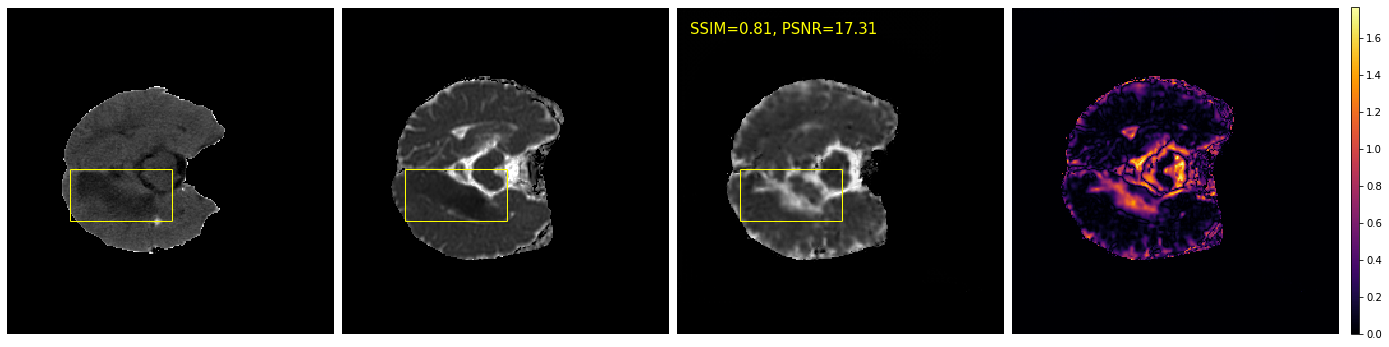

0.8102315553167316 19.9395359429375


In [25]:
fn = "train_054_r1_mask_10.png"
h_start,h_end,v_start,v_end = maskbox(fn)

myimg = mpimg.imread("data/custom-ncct2adc/old_2023/testA/train_054_ncct_10.png")
myimg = (myimg*2)-1
#myimg999 = mpimg.imread("data/custom-ncct2adc/testA/train_054_ncct_10.png")
myimg999 = mpimg.imread("data/custom-ncct2adc/trainA/train_054_ncct_10.png")
myimg999 = (myimg999*2)-1
#print(np.min(myimg999), np.max(myimg999))
#print(myimg999.shape)

#mypred = model['G_A2B'].predict(myimg999[np.newaxis,:,:,:1])
mypred = model['G_A2B'].predict(myimg[np.newaxis,:,:,:1])

fig = plt.figure(figsize=(24,6))
plt.subplot(1,4,1)
plt.imshow(myimg999[:,:,0], cmap="gray")
plt.hlines(y=v_start, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid", lw=1)
plt.hlines(y=v_end, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid", lw=1)
plt.vlines(x=h_start, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid", lw=1)
plt.vlines(x=h_end, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid", lw=1)
plt.axis('off')

myimg999 = mpimg.imread("data/custom-ncct2adc/trainB/train_054_adc_10.png")
myimg999 = (myimg999*2)-1
plt.subplot(1,4,2)
plt.imshow(myimg999[:,:,0], cmap="gray")
plt.hlines(y=v_start, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid", lw=1)
plt.hlines(y=v_end, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid", lw=1)
plt.vlines(x=h_start, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid", lw=1)
plt.vlines(x=h_end, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid", lw=1)
plt.axis('off')


plt.subplot(1,4,3)
plt.imshow(mypred[0,:,:,0], cmap="gray")
plt.hlines(y=v_start, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid", lw=1)
plt.hlines(y=v_end, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid", lw=1)
plt.vlines(x=h_start, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid", lw=1)
plt.vlines(x=h_end, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid", lw=1)
plt.text(10,20,"SSIM=0.81, PSNR=17.31", color="yellow", size=15)
plt.axis('off')

plt.subplot(1,4,4)
#plt.imshow(myimg999[:,:,0]-mypred[0,:,:,0], cmap="inferno", vmin=-1, vmax=1)
plt.imshow(np.abs(myimg999[:,:,0]-mypred[0,:,:,0]), cmap="inferno")
plt.axis('off')

cax = plt.axes([0.905, 0.125, 0.005, 0.757])
plt.colorbar(cax=cax)

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("ncct2adc-vanilla.png", pad_inches=0, bbox_inches='tight')
plt.show()

s1 = ssim(myimg999[:,:,0], mypred[0,:,:,0])
s2 = psnr(myimg999[:,:,0], mypred[0,:,:,0])
print(s1,s2)

(1, 256, 256, 1)


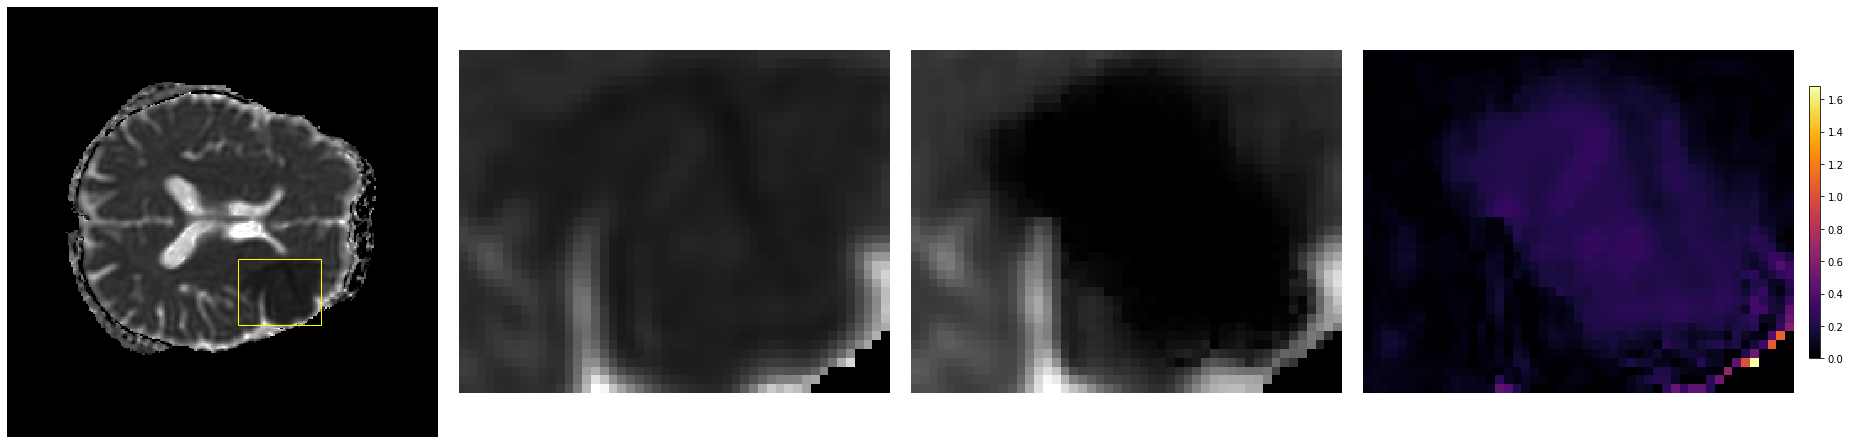

In [24]:
fn = "train_053_r1_mask_15.png"
h_start,h_end,v_start,v_end = maskbox(fn)

pathimg = "data-old/foscal/maskA/train_053_mask_15.png"
imgmask = mpimg.imread(pathimg)

pathimg2 = "data/custom-ncct2adc/trainB/train_053_adc_15.png"
img2 = mpimg.imread(pathimg2)
img2 = (img2*2)-1

# img = opt['B_test'][131]
synthetic_images_B = model['G_B2A'].predict(img2[np.newaxis,:,:,:1])
reconstructed_image_A = model['G_A2B'].predict(synthetic_images_B)
# print(img.shape)
print(reconstructed_image_A.shape)

plt.figure(figsize=(32,8))

# plt.subplot(1,4,1)
# plt.imshow(img2[:,:,0], cmap="gray")
# plt.imshow(imgmask[:,:,0], cmap="gray", alpha=0.8)
# plt.axis('off')

plt.subplot(1,4,1)
plt.imshow(img2[:,:,0], cmap="gray")
#plt.imshow(imgmask[:,:,0], cmap="gray", alpha=0.1)
plt.hlines(y=v_start, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid", lw=1)
plt.hlines(y=v_end, xmin=h_start, xmax=h_end, colors="yellow", linestyles="solid", lw=1)
plt.vlines(x=h_start, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid", lw=1)
plt.vlines(x=h_end, ymin=v_start, ymax=v_end, colors="yellow", linestyles="solid", lw=1)
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(img2[v_start:v_end,h_start:h_end,0], cmap="gray")
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(reconstructed_image_A[0,v_start:v_end,h_start:h_end,0], cmap="gray")
# plt.text(1.5,3,"SSIM=0.79, PSNR=22.02", color="yellow", size=14)
plt.axis('off')

plt.subplot(1,4,4)
#plt.imshow(reconstructed_image_A[0,v_start:v_end,h_start:h_end,0]-img2[v_start:v_end,h_start:h_end,0], cmap="inferno", vmin=-1, vmax=1)
plt.imshow(np.abs(reconstructed_image_A[0,v_start:v_end,h_start:h_end,0]-img2[v_start:v_end,h_start:h_end,0]), cmap="inferno")
plt.axis('off')
cax = plt.axes([0.907, 0.265, 0.005, 0.473])
plt.colorbar(cax=cax)

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig("ncct2adc-mask-vanilla.png", pad_inches=0, bbox_inches='tight')
plt.show()

# s1 = ssim(img2[v_start:v_end,h_start:h_end,0], reconstructed_image_A[0,v_start:v_end,h_start:h_end,0])
# s2 = psnr(img2[v_start:v_end,h_start:h_end,0], reconstructed_image_A[0,v_start:v_end,h_start:h_end,0])
# print(s1,s2)

In [76]:
all_s1 = []
all_s2 = []
all_s3 = []
all_s4 = []
all_s5 = []
all_s6 = []
all_s7 = []
all_s8 = []

for k,f in enumerate(opt['testA_image_names']):
    synthetic_images_B = model['G_A2B'].predict(opt['A_test'][k][np.newaxis,:])
    reconstructed_image_A = model['G_B2A'].predict(synthetic_images_B)
    s1 = ssim(opt['A_test'][k][:,:,0], reconstructed_image_A[0,:,:,0])
    s2 = psnr(opt['A_test'][k][:,:,0], reconstructed_image_A[0,:,:,0])
    all_s1.append(s1)
    all_s2.append(s2)
    print(f) #train_048_adc_10.png
    pts = f.split("_") #train_048_r1_mask_10.png
    fn = pts[0]+"_"+pts[1]+"_r1_mask_"+pts[3]
    s3 = s4 = s5 = s6 = s7 = s8 = 0
    
    #if os.path.isfile("data-old/customnoss/testmaskB/"+fnewx):
    if os.path.isfile("data-old/customnoss/testmaskB/"+fn):
        h_start,h_end,v_start,v_end = maskbox(fn)
        if h_start!=0 and h_end!=0 and v_start!=0 and v_end!=0:
            ws = None
            if opt['A_test'][k][h_start:h_end+1,v_start:v_end+1,0].shape[0]<7 or opt['A_test'][k][h_start:h_end+1,v_start:v_end+1,0].shape[1]<7:
                ws = 3
            s3 = ssim(opt['A_test'][k][h_start:h_end+1,v_start:v_end+1,0], reconstructed_image_A[0,h_start:h_end+1,v_start:v_end+1,0], win_size=ws)
            s4 = psnr(opt['A_test'][k][h_start:h_end+1,v_start:v_end+1,0], reconstructed_image_A[0,h_start:h_end+1,v_start:v_end+1,0])
            all_s3.append(s3)
            all_s4.append(s4)
    
    fnewx = f.replace("ncct","adc")
    #fnewx = pts[0]+"_"+pts[1]+"_dwi_"+pts[2]
    #fnewx = pts[0]+"_"+pts[1]+"_"+pts[3]
    print("paired:",fnewx)
    if os.path.isfile("data/"+image_folder+"/testB/"+fnewx):
        image = mpimg.imread("data/"+image_folder+"/testB/"+fnewx)
        image = image[:,:,0]
        image = (image*2)-1
        s5 = ssim(image, synthetic_images_B[0,:,:,0])
        s6 = psnr(image, synthetic_images_B[0,:,:,0])
        all_s5.append(s5)
        all_s6.append(s6)
#         plt.subplot(1,4,1)
#         plt.imshow(image, cmap="gray")
#         plt.subplot(1,4,2)
#         plt.imshow(synthetic_images_B[0,:,:,0], cmap="gray")
# #         plt.subplot(1,4,3)
# #         plt.imshow(reconstructed_image_A[0,:,:,0], cmap="gray")
# #         plt.subplot(1,4,4)
# #         plt.imshow(opt['A_test'][k][:,:,0], cmap="gray")
#         plt.show()
        if os.path.isfile("data-old/customnoss/testmaskB/"+fn):
            h_start,h_end,v_start,v_end = maskbox(fn)
            if h_start!=0 and h_end!=0 and v_start!=0 and v_end!=0:
                ws = None
                if image[h_start:h_end+1,v_start:v_end+1].shape[0]<7 or image[h_start:h_end+1,v_start:v_end+1].shape[1]<7:
                    ws = 3
                s7 = ssim(image[h_start:h_end+1,v_start:v_end+1], synthetic_images_B[0,h_start:h_end+1,v_start:v_end+1,0], win_size=ws)
                s8 = psnr(image[h_start:h_end+1,v_start:v_end+1], synthetic_images_B[0,h_start:h_end+1,v_start:v_end+1,0])
                all_s7.append(s7)
                all_s8.append(s8)
    
    print(s1, s2, s3, s4, s5, s6, s7, s8)
    #break

avg_s1 = np.mean(all_s1)
avg_s2 = np.mean(all_s2)
avg_s3 = np.mean(all_s3)
avg_s4 = np.mean(all_s4)
avg_s5 = np.mean(all_s5)
avg_s6 = np.mean(all_s6)
avg_s7 = np.mean(all_s7)
avg_s8 = np.mean(all_s8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  


train_048_ncct_1.png
paired: train_048_adc_1.png
0.9717030608175626 27.527819716829747 0 0 0 0 0 0
train_048_ncct_10.png
paired: train_048_adc_10.png
0.8660196955445414 23.72147595552908 0 0 0.7614757523086855 17.663103571161557 0 0
train_048_ncct_11.png
paired: train_048_adc_11.png
0.8666851218446026 23.73902787814648 0 0 0.7530507074486673 19.062826220338923 0 0
train_048_ncct_12.png
paired: train_048_adc_12.png
0.8461414917797103 23.914624834179534 0 0 0.760121240769403 20.036511620498377 0 0
train_048_ncct_13.png
paired: train_048_adc_13.png
0.8576285281262518 25.009399755870668 0 0 0.7583170357992569 20.050002734262993 0 0
train_048_ncct_14.png
paired: train_048_adc_14.png
0.8568463687278098 24.632222079401856 0 0 0.7549736557580304 19.85390709040494 0 0
train_048_ncct_15.png
paired: train_048_adc_15.png
0.8615670423773404 25.273242630277114 0 0 0.7872164860086548 22.02413154510746 0 0
train_048_ncct_16.png
paired: train_048_adc_16.png
0.8638940797627572 25.614722931583813 0 0 0.8

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


0.8985516066167942 26.28407870426934 0.7493826754683143 30.133657818352507 0.780454005506984 20.598725693892916 -0.21133842515252632 14.513324775376715
train_049_ncct_16.png
paired: train_049_adc_16.png
0.899572146163394 25.370611011329018 0.7694406440899723 35.14781543402336 0.8191564719831692 22.184719250596977 0.6075788626955897 29.593439862513364
train_049_ncct_17.png
paired: train_049_adc_17.png
0.913431975061424 26.10133884605507 0 0 0.8092581456469352 21.373507339738005 0 0
train_049_ncct_18.png
paired: train_049_adc_18.png
0.9141232274871627 26.477951305194058 0.4430077722683036 27.184918988767794 0.8051864410286155 20.980945790785807 0.24100415317446391 13.645064979686019
train_049_ncct_19.png
paired: train_049_adc_19.png
0.92578036859386 26.57979972066471 0 0 0.8227279365922592 20.450344354589667 0 0
train_049_ncct_2.png
paired: train_049_adc_2.png
0.989943367014987 30.22957363647455 0 0 0 0 0 0
train_049_ncct_20.png
paired: train_049_adc_20.png
0.9367251453012587 26.70454984

0.9008896695960937 23.157268133960027 0 0 0.7986529470132874 20.504960538762784 0 0
train_052_ncct_1.png
paired: train_052_adc_1.png
0.9362173404629007 24.430828132561302 0 0 0 0 0 0
train_052_ncct_10.png
paired: train_052_adc_10.png
0.8385812039657061 21.660622116534952 0 0 0.6666637969205286 16.54607781865636 0 0
train_052_ncct_11.png
paired: train_052_adc_11.png
0.841490498266509 22.233208890914252 0 0 0.6565839435646225 16.663551546381512 0 0
train_052_ncct_12.png
paired: train_052_adc_12.png
0.8437034427256702 22.529947941100197 0 0 0.6623261130507123 17.77187713426699 0 0
train_052_ncct_13.png
paired: train_052_adc_13.png
0.8409251164632403 22.625035683135355 0 0 0.6727232647010253 18.778374966188665 0 0
train_052_ncct_14.png
paired: train_052_adc_14.png
0.8428515994817953 22.888177475197725 0 0 0.6792596758758638 18.780022869070464 0 0
train_052_ncct_15.png
paired: train_052_adc_15.png
0.8383890117323936 22.500447414504514 0 0 0.7159374589175276 18.966218918963243 0 0
train_052_

0.896042320859668 25.072301820531507 0 0 0.8275902092511577 21.510855928027688 0 0
train_054_ncct_19.png
paired: train_054_adc_19.png
0.9061486113485496 25.161157027371466 0 0 0.8325303340393304 21.702386875582253 0 0
train_054_ncct_2.png
paired: train_054_adc_2.png
0.9565457941372463 24.754374979316314 0 0 0 0 0 0
train_054_ncct_20.png
paired: train_054_adc_20.png
0.9186512508363375 24.546328622861576 0 0 0.8484109942371219 21.847888776038168 0 0
train_054_ncct_21.png
paired: train_054_adc_21.png
0.9393214942661702 25.53928493442047 0 0 0.8791674767105607 22.263178209812718 0 0
train_054_ncct_22.png
paired: train_054_adc_22.png
0.9568866799594271 26.963724723804518 0 0 0 0 0 0
train_054_ncct_23.png
paired: train_054_adc_23.png
0.9730182583470529 27.33658531025581 0 0 0 0 0 0
train_054_ncct_24.png
paired: train_054_adc_24.png
0.9999999890991451 108.59880215283619 0 0 0 0 0 0
train_054_ncct_3.png
paired: train_054_adc_3.png
0.9648340498594086 25.497478406976214 0 0 0 0 0 0
train_054_ncc

train_057_ncct_1.png
paired: train_057_adc_1.png
0.9866885494101814 27.16354581405919 0 0 0 0 0 0
train_057_ncct_10.png
paired: train_057_adc_10.png
0.8758144812902298 24.016997322039735 0.5929587138707832 17.263348272829028 0.7767387022280223 19.459697102520966 0.24087582983049885 14.894963297800334
train_057_ncct_11.png
paired: train_057_adc_11.png
0.874461683825589 24.369058553907234 0.5096481724213994 21.033744660232607 0.7732426342907334 18.154122229188946 0.23920732871108663 13.991225976878267
train_057_ncct_12.png
paired: train_057_adc_12.png
0.8643713135352626 24.257896841636786 0.5140371322902765 19.26451744344206 0.7330620013037077 17.78408642103383 0.2363452044820453 14.978407692198804
train_057_ncct_13.png
paired: train_057_adc_13.png
0.8552317274066711 23.830756449769666 0.6004032030982275 20.667779953202402 0.7059747513582181 17.39171296621635 0.08106442201669237 13.098178444033561
train_057_ncct_14.png
paired: train_057_adc_14.png
0.8460796706635845 24.388873154802276 0.

paired: train_059_adc_22.png
0.9102862537310621 26.094060199078243 0 0 0.859014622358774 20.999686624910172 0 0
train_059_ncct_23.png
paired: train_059_adc_23.png
0.9321096200523206 26.152166034879194 0 0 0 0 0 0
train_059_ncct_24.png
paired: train_059_adc_24.png
0.9436188686031566 18.124469592261747 0 0 0 0 0 0
train_059_ncct_3.png
paired: train_059_adc_3.png
0.9186371553361218 22.764652107014385 0 0 0 0 0 0
train_059_ncct_4.png
paired: train_059_adc_4.png
0.9083907157169923 22.08652197974708 0 0 0 0 0 0
train_059_ncct_5.png
paired: train_059_adc_5.png
0.8932748353835521 21.306822879418547 0 0 0 0 0 0
train_059_ncct_6.png
paired: train_059_adc_6.png
0.8731031346500118 21.033819078313076 0 0 0 0 0 0
train_059_ncct_7.png
paired: train_059_adc_7.png
0.8648632397422488 20.968917812258596 0 0 0 0 0 0
train_059_ncct_8.png
paired: train_059_adc_8.png
0.8618321306943314 19.78960134537384 0 0 0.6954767876401743 17.904587044168863 0 0
train_059_ncct_9.png
paired: train_059_adc_9.png
0.864722264

In [77]:
print("NCCT reconstruction")
print("ssim","\t\tpsnr","\t\tssim-mask","\t\tpsnr-mask")
avg_s1, avg_s2, avg_s3, avg_s4, avg_s5, avg_s6, avg_s7, avg_s8
#avg_s1, avg_s2

NCCT reconstruction
ssim 		psnr 		ssim-mask 		psnr-mask


(0.9019823812155846,
 27.11165341919095,
 0.60765852553446,
 23.473444676259874,
 0.7674675562811182,
 19.836942056933907,
 0.16680316176206741,
 14.104774247133347)

<br><br><br><br>

# Training data

In [ ]:
#import keras
#from tensorflow.keras.utils import plot_model
#tf.keras.utils.plot_model(model)

In [ ]:
import keras
import seaborn as sns

capa_o = keras.models.Model(inputs=model["G_A2B"].get_input_at(0), outputs=model["G_A2B"].get_layer('add12').output)
capa_o2 = keras.models.Model(inputs=model["G_B2A"].get_input_at(0), outputs=model["G_B2A"].get_layer('add12').output)

In [ ]:
synthetic_images_B = model['G_A2B'].predict(opt['A_train'])

synthetic_images_B_CTHEALTHY = model['G_A2B'].predict(opt['CTHEALTHY_images'])
synthetic_images_B_CTFOSCAL = model['G_A2B'].predict(opt['CTFOSCAL_images'])

print(opt['trainA_image_names'][0])
print(opt['CTHEALTHY_image_names'][0])
print(opt['CTFOSCAL_image_names'][0])

emb = capa_o.predict(synthetic_images_B)
print(emb[:,0,0,:].shape, emb.shape)

emb2 = capa_o2.predict(opt['B_train'])
print(emb2[:,0,0,:].shape)

emb3 = capa_o2.predict(synthetic_images_B_CTHEALTHY)
print(emb3[:,0,0,:].shape)

emb4 = capa_o2.predict(synthetic_images_B_CTFOSCAL)
print(emb4[:,0,0,:].shape)

## PCA 2 COMPONENTS

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
comp = pca.fit_transform(emb[:,0,0,:])

pca2 = PCA(n_components=2)
comp2 = pca2.fit_transform(emb2[:,0,0,:])

pca3 = PCA(n_components=2)
comp3 = pca3.fit_transform(emb3[:,0,0,:])

pca4 = PCA(n_components=2)
comp4 = pca4.fit_transform(emb4[:,0,0,:])

# Synthetic MRI space

In [ ]:
plt.scatter(comp[:,0], comp[:,1], label="Synthetic MRI", alpha=0.5)
plt.scatter(comp2[:,0], comp2[:,1], label="MRI_train", alpha=0.3)
plt.scatter(comp3[:,0], comp3[:,1], label="Synthetic MRI CTHEALTHY", alpha=0.1)
plt.scatter(comp4[:,0], comp4[:,1], label="Synthetic MRI CTFOSCAL", alpha=0.3)
#plt.xlim((-50,50))
#plt.ylim((-20,20))
plt.legend()
plt.show()

In [ ]:
import umap

print(emb.shape)
print(emb2.shape)
um = umap.UMAP().fit_transform(emb[:,0,0,:])
um2 = umap.UMAP().fit_transform(emb2[:,0,0,:])
um3 = umap.UMAP().fit_transform(emb3[:,0,0,:])
um4 = umap.UMAP().fit_transform(emb4[:,0,0,:])

plt.scatter(um[:,0], um[:,1], label="Synthetic MRI", alpha=0.5)
plt.scatter(um2[:,0], um2[:,1], label="MRI_train", alpha=0.5)
plt.scatter(um3[:,0], um3[:,1], label="Synthetic MRI CTHEALTHY", alpha=0.5)
plt.scatter(um4[:,0], um4[:,1], label="Synthetic MRI CTFOSCAL", alpha=0.5)
plt.legend()
plt.show()

## Ischemic lesion (Stroke) / no-Stroke over Synthetic MRI space

In [ ]:
import pandas as pd
import seaborn as sns
import os

d = pd.read_csv("data/xxx2.csv")

print(opt['trainA_image_names'][0])

mb_list = []
mb_synth_ns = []
mb_synth_stroke = []

print(type(comp))
for i in range(len(opt['trainA_image_names'])):
    #fname, comp[i,0], comp[i,1], maskbin
    mb_list.append(list(d.loc[d["CT"] == opt['trainA_image_names'][i]]["maskbin"])[0])
    if (list(d.loc[d["CT"] == opt['trainA_image_names'][i]]["maskbin"])[0]==0):
        mb_synth_ns.append([comp[i,0], comp[i,1]])
    else:
        mb_synth_stroke.append([comp[i,0], comp[i,1]])

mb_synth_ns = np.array(mb_synth_ns)
mb_synth_stroke = np.array(mb_synth_stroke)


#CENTROIDES
c_stroke = np.mean(mb_synth_stroke, axis=0)
c_ns = np.mean(mb_synth_ns, axis=0)
c_h = np.mean(comp3, axis=0)
print(c_stroke)
print(c_ns)
print(c_h)
#for i in mb_synth_stroke.shape[0]:
#    mb_synth_stroke[:,0]


#d = {'files': opt["trainA_image_names"], 'maskbin': mb_list, 'x_umap': um[:,0], 'y_umap': um[:,1], 'x_pca': comp[:,0], 'y_pca': comp[:,1]}
d = {'files': opt["trainA_image_names"], 'maskbin': mb_list, 'x_pca': comp[:,0], 'y_pca': comp[:,1]}
d = pd.DataFrame(data=d)

#sns.set(rc={'figure.figsize':(8,5)})
#sns.scatterplot(data=d, x="x_pca", y="y_pca", hue="maskbin", alpha=0.9)
plt.figure(figsize=(10,6))

plt.scatter(mb_synth_stroke[:,0], mb_synth_stroke[:,1], label="1 (stroke) Synthetic", alpha=0.3, s=20, marker=".", color="#FF6600")
plt.scatter(mb_synth_ns[:,0], mb_synth_ns[:,1], label="0 (negative) Synthetic", alpha=0.6, s=20, marker=".", color="#0000FF")
plt.scatter(comp3[:,0], comp3[:,1], label="Synthetic MRI CTHEALTHY", alpha=0.1, s=20, marker=".", color="#00AA00")
plt.scatter(c_stroke[0], c_stroke[1], label="", alpha=1, s=100, marker="x", color="#FF3300")
plt.scatter(c_ns[0], c_ns[1], label="", alpha=1, s=100, marker="x", color="#0000FF")
plt.scatter(c_h[0], c_h[1], label="", alpha=1, s=100, marker="x", color="#146d01")
plt.scatter(comp4[:,0], comp4[:,1], label="Synthetic MRI CTFOSCAL", alpha=0.8, s=5, color="#FF0000")
#plt.xticks(np.arange(-3, 20, 1))
plt.xlim((-50,50))
plt.ylim((-20,20))
plt.legend(framealpha=0.5)
plt.show()

In [ ]:
for k in range(d.shape[0]):
    if(d.iloc[k]["x_pca"]>-2 and d.iloc[k]["x_pca"]<-1 and d.iloc[k]["y_pca"]>0 and d.iloc[k]["y_pca"]<2
       and d.iloc[k]["maskbin"]==1):
        print(d.iloc[k]["maskbin"], d.iloc[k]["x_pca"], d.iloc[k]["y_pca"], d.iloc[k]["files"])

<br><br><br>

## PCA 3 COMPONENTS

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
comp_3d = pca.fit_transform(emb[:,0,0,:])

#pca2 = PCA(n_components=3)
#comp2 = pca2.fit_transform(emb2[:,0,0,:])

pca3 = PCA(n_components=3)
comp3_3d = pca3.fit_transform(emb3[:,0,0,:])

pca4 = PCA(n_components=3)
comp4_3d = pca4.fit_transform(emb4[:,0,0,:])

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

d = pd.read_csv("data/xxx2.csv")

print(opt['trainA_image_names'][0])

mb_list = []
mb_synth_ns = []
mb_synth_stroke = []

print(type(comp))
for i in range(len(opt['trainA_image_names'])):
    #fname, comp[i,0], comp[i,1], maskbin
    mb_list.append(list(d.loc[d["CT"] == opt['trainA_image_names'][i]]["maskbin"])[0])
    if (list(d.loc[d["CT"] == opt['trainA_image_names'][i]]["maskbin"])[0]==0):
        mb_synth_ns.append([comp_3d[i,0], comp_3d[i,1], comp_3d[i,2]])
    else:
        mb_synth_stroke.append([comp_3d[i,0], comp_3d[i,1], comp_3d[i,2]])

mb_synth_ns = np.array(mb_synth_ns)
mb_synth_stroke = np.array(mb_synth_stroke)


#d = {'files': opt["trainA_image_names"], 'maskbin': mb_list, 'x_umap': um[:,0], 'y_umap': um[:,1], 'x_pca': comp[:,0], 'y_pca': comp[:,1]}
d = {'files': opt["trainA_image_names"], 'maskbin': mb_list, 'x_pca': comp_3d[:,0], 'y_pca': comp_3d[:,1], 'z_pca': comp_3d[:,2]}
d = pd.DataFrame(data=d)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(mb_synth_ns[:,0], mb_synth_ns[:,1], mb_synth_ns[:,2], marker=m)
ax.scatter(mb_synth_stroke[:,0], mb_synth_stroke[:,1], mb_synth_stroke[:,2], marker=m)
ax.scatter(comp3_3d[:,0], comp3_3d[:,1], comp3_3d[:,2], marker=m)
ax.scatter(comp4_3d[:,0], comp4_3d[:,1], comp4_3d[:,2], marker=m)

ax.set_xlim((-40,10))
ax.set_ylim((-10,20))
ax.set_zlim((-10,10))

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.view_init(45, -45)

plt.show()

### UMAP

In [ ]:
import umap

print(emb.shape)
print(emb2.shape)
um = umap.UMAP().fit_transform(emb[:,0,0,:])
um2 = umap.UMAP().fit_transform(emb2[:,0,0,:])
um3 = umap.UMAP().fit_transform(emb3[:,0,0,:])
um4 = umap.UMAP().fit_transform(emb4[:,0,0,:])

plt.scatter(um[:,0], um[:,1], label="Synthetic MRI", alpha=0.5)
plt.scatter(um2[:,0], um2[:,1], label="MRI_train", alpha=0.5)
plt.scatter(um3[:,0], um3[:,1], label="Synthetic MRI CTHEALTHY", alpha=0.5)
plt.scatter(um4[:,0], um4[:,1], label="Synthetic MRI CTFOSCAL", alpha=0.5)
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import os

d = pd.read_csv("data/xxx2.csv")

print(opt['trainA_image_names'][0])

mb_list = []

for i in range(len(opt['trainA_image_names'])):
    #fname, comp[i,0], comp[i,1], maskbin
    mb_list.append(list(d.loc[d["CT"] == opt['trainA_image_names'][i]]["maskbin"])[0])

d = {'files': opt["trainA_image_names"], 'maskbin': mb_list, 'x_umap': um[:,0], 'y_umap': um[:,1], 'x_pca': comp[:,0], 'y_pca': comp[:,1]}
d = pd.DataFrame(data=d)
#d.head()
#d.to_csv('pd-maskbin-'+str(ep)+'epoch.csv')

#sns.scatterplot(data=d, x="x_pca", y="y_pca", hue="maskbin")
sns.set(rc={'figure.figsize':(8,5)})
sns.scatterplot(data=d, x="x_umap", y="y_umap", hue="maskbin", alpha=0.6)
